# Remove cell cycle from perturbed mESC

Here we use the mESC dataset with 600 cell cycle genes and 1000 other gene expressions doubled for 40% cells. For simplicity we have converted the dataset into TPM.

## Import necessary packages

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import sys

import pandas as pd
import numpy as np
import pickle as pkl
import sklearn as skl
import sklearn.preprocessing

import matplotlib as mpl

import matplotlib.pyplot as plt


Warning information from TensorFlow may occur. It doesn't matter.

In [3]:
import tensorflow as tf
tf.set_random_seed(0)
import cyclum
from cyclum import writer

/home/shaoheng/.conda/envs/tensorflow-gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
input_file_mask = 'data/mESC/perturbed-mesc-tpm-linear'

## Read data
Here we have label, so we load both. However, the label is not used until evaluation.

In [5]:
def preprocess(input_file_mask):
    """
    Read in data and perform log transform (log2(x+1)), centering (mean = 1) and scaling (sd = 1).
    """
    tpm = writer.read_df_from_binary(input_file_mask)
    sttpm = pd.DataFrame(data=skl.preprocessing.scale(np.log2(tpm.values + 1)), index=tpm.index, columns=tpm.columns)
    
    label = pd.read_csv(input_file_mask + '-label.csv', sep="\t", index_col=0)
    return sttpm, label

sttpm, label = preprocess(input_file_mask)

There is no convention whether cells should be columns or rows. Here we require cells to be rows.

In [6]:
sttpm.head()

,Gnai3,Pbsn,Cdc45,H19,Scml2,Apoh,Narf,Cav2,Klf6,Scmh1,...,RP23-345J21.2,AC121960.1,AC136147.1,AC122013.1,AC132389.1,Gm11392,AC160109.2,AC154675.1,AC156980.1,RP23-429I18.1
G1_cell1_count,-0.240365,-0.059976,0.077328,5.298087,-0.714166,0.0,-0.707230,-0.059976,-1.114342,-0.368917,...,-0.149121,0.0,-0.080859,-0.381839,-0.846925,-0.059976,-0.081147,0.0,-0.147211,0.049833
G1_cell2_count,-0.368984,-0.059976,0.615395,-0.168451,-0.842523,0.0,0.337309,-0.059976,1.437104,0.184563,...,-0.149121,0.0,-0.080859,-0.381839,-0.846925,-0.059976,-0.081147,0.0,-0.147211,-1.326395
G1_cell3_count,-1.588597,-0.059976,-1.439700,-0.168451,-0.842523,0.0,-0.707230,-0.059976,-1.337381,-0.672972,...,2.548733,0.0,-0.080859,-0.381839,-0.616570,-0.059976,-0.081147,0.0,-0.147211,-1.326395
G1_cell4_count,-2.043812,-0.059976,0.766249,-0.168451,-0.842523,0.0,0.873861,-0.059976,1.408474,-0.672972,...,-0.149121,0.0,-0.080859,-0.381839,2.898387,-0.059976,-0.081147,0.0,-0.147211,-1.326395
G1_cell5_count,-1.668098,-0.059976,0.182776,-0.168451,-0.842523,0.0,-0.707230,-0.059976,-0.869770,-0.672972,...,-0.149121,0.0,-0.080859,-0.381839,-0.846925,-0.059976,-0.081147,0.0,-0.147211,-0.154229


In [7]:
label.head()

,stage,subcluster
G1_cell1_count,g0/g1,perturbed
G1_cell2_count,g0/g1,intact
G1_cell3_count,g0/g1,intact
G1_cell4_count,g0/g1,intact
G1_cell5_count,g0/g1,perturbed


## Set up the model and fit the model

Fitting the model may take some time. Using a GTX 960M GPU it takes 6 minutes.

In [8]:
model = cyclum.PreloadCyclum(sttpm.values, q_circular=3, q_linear=1)

In [9]:
pseudotime, rotation = model.fit()

pretrain burnin
step  2000: loss [0.17363924, 38648384.0, 143098.72] time 9.98
pretrain train
step  2000: loss [0.17294206, 38648396.0, 143098.72] time 7.21
step  4000: loss [0.17294218, 38648390.0, 143098.72] time 6.14
midtrain burnin
step  2000: loss [0.17294218, 13706.275, 66501.27] time 30.63
midtrain train
step  2000: loss [0.17294218, 13703.313, 66501.27] time 30.84
step  4000: loss [0.17294218, 13703.31, 66501.27] time 28.50
finaltrain train
step  2000: loss [0.25978315, 13456.805, 36317.523] time 41.18
step  4000: loss [0.3560579, 13454.46, 19613.684] time 37.69
step  6000: loss [0.40473315, 13453.682, 10077.552] time 37.72
finaltrain refine
step  2000: loss [0.41543347, 13453.116, 8114.8086] time 41.51
step  4000: loss [0.43487915, 13452.949, 6591.534] time 37.74
step  6000: loss [0.44793454, 13452.951, 5367.22] time 37.72
step  8000: loss [0.45629007, 13452.896, 4374.1514] time 37.78
step 10000: loss [0.45684564, 13452.864, 3562.853] time 37.73
Full time 422.85


## Illustrations
We illustrate the results on a circle, to show its circular nature. 
There is virtually no start and end of the circle.
Red, green and blue represents G0/G1, S and G2/M phase respectively.
The inner lines represents single cells. The cells spread across the
The areas outside

In [10]:
%aimport cyclum.illustration

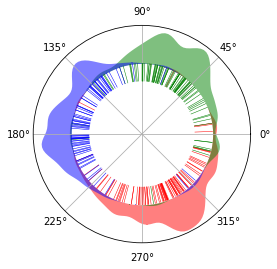

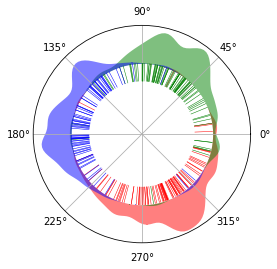

In [11]:
color_map = {'stage': {"g0/g1": "red", "s": "green", "g2/m": "blue"},
                 'subcluster': {"intact": "cyan", "perturbed": "violet"}}
cyclum.illustration.plot_round_distr_color(pseudotime, label['stage'], color_map['stage'])

## Subclone analysis
Many analysis are done in R, so we also choose R to do this job. 
On the jupyter/python side, package rpy2 is needed to run R inline.
On the R side, packages Rtsne and matrixStats are required.
It takes some time to transfer data from python to R.

The data corrected by cyclum shows better separation of two subclones in the tsne plot.

In [12]:
sttpm2 = sttpm - np.concatenate([np.cos(pseudotime + i * 2 * np.pi / 3) for i in range(3)], axis=1) @ rotation

In [13]:
%load_ext rpy2.ipython

In [38]:
%%R
library(Rtsne)
library(matrixStats)
library(mclust)

calc_class_score_cv <- function(x, cls){
  cv = cvMclustDA(MclustDA(x, cls, G=1, verbose = F), verbose = F)
  return(1 - cv$error)
}

In [14]:
%R -i label
%R -i sttpm sttpm = as.matrix(sttpm)
%R -i sttpm2 sttpm2 = as.matrix(sttpm2)
%R print(dim(sttpm))

/home/shaoheng/.conda/envs/tensorflow-gpu/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:190: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[1]   279 38293


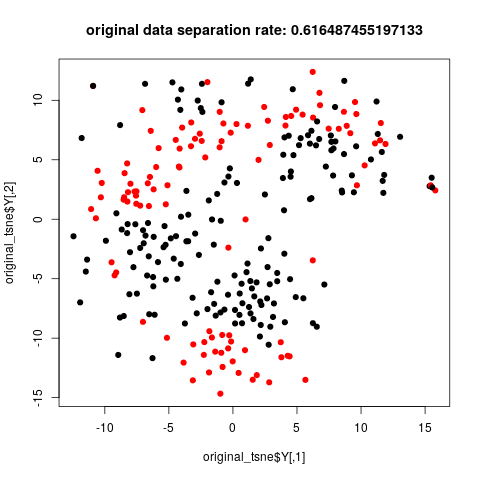

In [48]:
%%R 

set.seed(2019)

nonzero_mask <- colSds(sttpm) > 1e-3
original_tsne <- Rtsne(sttpm[, nonzero_mask], pca_scale = TRUE, theta=0.1)
plot(original_tsne$Y, col=as.factor(label$subcluster), pch=19)
title(paste('original data separation rate:', calc_class_score_cv(original_tsne$Y, label$subcluster)))

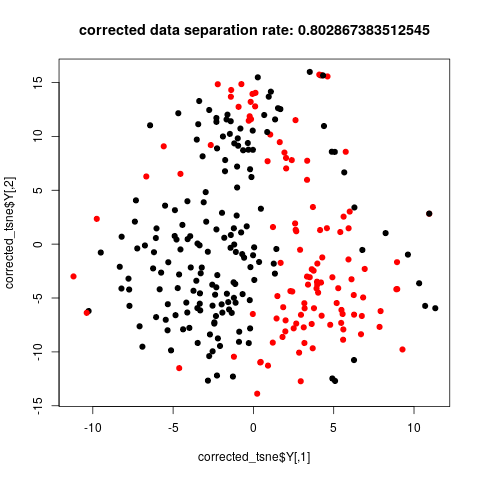

In [49]:
%%R 

nonzero_mask <- colSds(sttpm2) > 1e-3
corrected_tsne <- Rtsne(sttpm2[, nonzero_mask], pca_scale = TRUE, theta=0.1)
plot(corrected_tsne$Y, col=as.factor(label$subcluster), pch=19)
title(paste('corrected data separation rate:', calc_class_score_cv(corrected_tsne$Y, label$subcluster)))